In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from scipy.stats import entropy
import matplotlib.pyplot as plt
from collections import Counter
from keras.regularizers import l2

from sklearn.metrics import f1_score
from sklearn.utils import class_weight
import nlpaug.augmenter.word as naw
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils.class_weight import compute_class_weight

from transformers import TFBertModel, AutoTokenizer, TFAutoModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, TextVectorization, Dense, BatchNormalization, Attention, GlobalMaxPooling1D

import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
# Step 1: Load the dataset
df_raw = pd.read_csv('full_final_data.csv')

In [3]:
df_raw.shape

(10039, 4)

In [4]:
df_raw['emotion'].value_counts(normalize=True)

emotion
xxx    0.249726
fru    0.184182
neu    0.170136
ang    0.109872
sad    0.107979
exc    0.103696
hap    0.059269
sur    0.010658
fea    0.003984
oth    0.000299
dis    0.000199
Name: proportion, dtype: float64

In [5]:
df_raw.head(5)

,session,speaker,text,emotion
0,Ses01F_impro01,F000,Excuse me.,neu
1,Ses01F_impro01,M000,Do you have your forms?,fru
2,Ses01F_impro01,F001,Yeah.,neu
3,Ses01F_impro01,M001,Let me see them.,fru
4,Ses01F_impro01,F002,Is there a problem?,neu


In [6]:
def add_context(df, k=2):
    """
    Add previous k utterances as context to each utterance within a session.
    
    Args:
        df (pd.DataFrame): Dataframe with 'session' and 'text' columns.
        k (int): Number of previous utterances to include.

    Returns:
        pd.DataFrame: Dataframe with new 'context_text' column.
    """
    df = df.copy()
    df['context_text'] = ""

    all_contexts = []

    for _, group in df.groupby('session'):
        group = group.reset_index(drop=True)
        context_list = []

        for i in range(len(group)):
            # Grab up to k previous utterances
            context_parts = [group.loc[j, 'text'] for j in range(max(0, i - k), i)]
            current_text = group.loc[i, 'text']
            context_full = " ".join(context_parts + [current_text])
            context_list.append(context_full)

        all_contexts.extend(context_list)

    df['context_text'] = all_contexts
    return df


In [7]:
df_raw = add_context(df_raw, k=2)
df = df_raw[['context_text', 'emotion']]
df = df.rename({'context_text' : 'text'}, axis=1)

In [8]:
df.head(10)

,text,emotion
0,Excuse me.,neu
1,Excuse me. Do you have your forms?,fru
2,Excuse me. Do you have your forms? Yeah.,neu
3,Do you have your forms? Yeah. Let me see them.,fru
4,Yeah. Let me see them. Is there a problem?,neu
5,Let me see them. Is there a problem? Who told ...,fru
6,Is there a problem? Who told you to get in thi...,xxx
7,Who told you to get in this line? You did. You...,xxx
8,You did. You were standing at the beginning an...,fru
9,You were standing at the beginning and you dir...,neu


In [11]:
pool = df[df['emotion'] == 'xxx']

In [13]:
df = df[~((df['emotion'] == 'oth') | (df['emotion'] == 'dis') | (df['emotion'] == 'xxx'))]

In [14]:
df.shape

(7527, 2)

In [15]:
# Ensure the columns are named 'text' and 'emotion_label'
X = df['text'].values


label2id = {label: i for i, label in enumerate(df['emotion'].unique())}
id2label = {i: label for label, i in label2id.items()}
y = df['emotion'].map(label2id).values

In [ ]:
label2id

{'neu': 0,
 'fru': 1,
 'ang': 2,
 'sad': 3,
 'hap': 4,
 'sur': 5,
 'exc': 6,
 'fea': 7}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [18]:
len(X_train)

6021

In [19]:
len(X_test)

1506

In [20]:
len(pool)

2507

In [22]:
# Define vectorizer
vocab_size = 3000
max_length = 150

text_vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=max_length)
text_vectorizer.adapt(X_train)  # 'texts' is your list of raw text samples

X_train = text_vectorizer(X_train)
X_test = text_vectorizer(X_test)

In [24]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=200, input_length=150),
    Bidirectional(LSTM(64, return_sequences=True)),  # Note: return_sequences=True
    GlobalMaxPooling1D(),  # This pools the most dominant features across time steps
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Assuming 8 emotion classes
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss=sparse_focal_loss(gamma=2.0, alpha=0.25), optimizer='adam', metrics=['accuracy'])
model.summary()

d:\Clg\sem6\Project\keras_env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))


history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20, 
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 92s 397ms/step - accuracy: 0.1248 - loss: 2.5314 - val_accuracy: 0.2357 - val_loss: 2.0949 - learning_rate: 0.0010
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 27s 141ms/step - accuracy: 0.2717 - loss: 1.9173 - val_accuracy: 0.3825 - val_loss: 1.6771 - learning_rate: 0.0010
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3410 - loss: 1.5060 - val_accuracy: 0.3367 - val_loss: 1.5472 - learning_rate: 0.0010
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.3974 - loss: 1.2799 - val_accuracy: 0.3818 - val_loss: 1.5157 - learning_rate: 0.0010
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.4678 - loss: 1.1819 - val_accuracy: 0.4575 - val_loss: 1.3968 - learning_rate: 0.0010
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.5231 - loss: 1.0577 - val_accuracy: 0.4754 - val_loss: 1.4428 - learning_rate: 0.0010
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5650 -

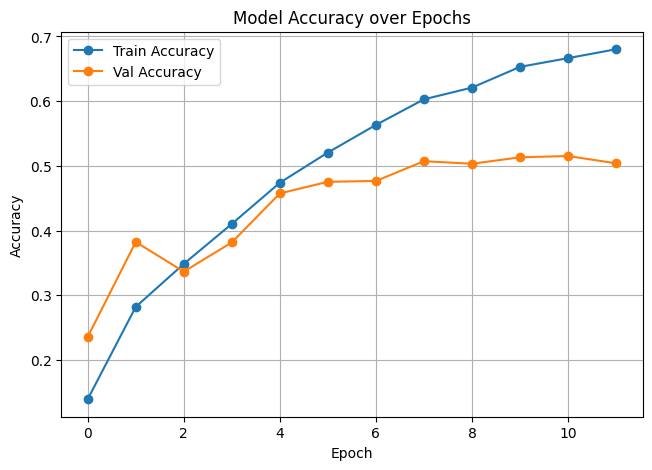

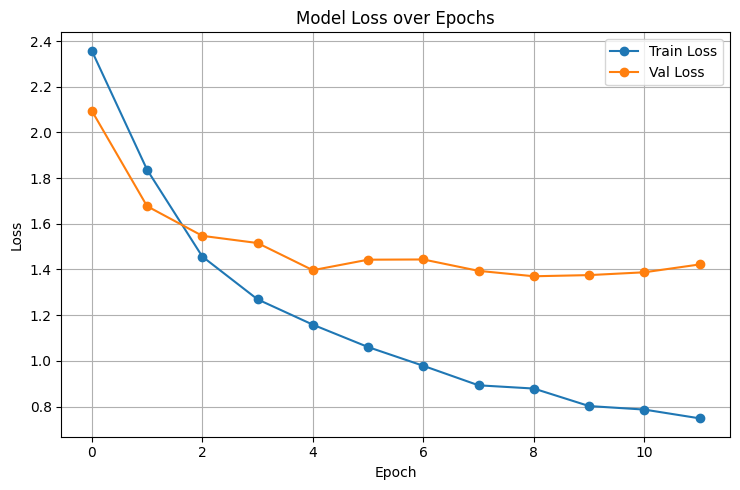

In [38]:
# Accuracy
plt.figure(figsize=(7.5, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker = 'o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker = 'o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

# Loss
plt.figure(figsize=(7.5, 5))
plt.plot(history.history['loss'], label='Train Loss', marker = 'o')
plt.plot(history.history['val_loss'], label='Val Loss', marker = 'o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
              precision    recall  f1-score   support

           0       0.42      0.36      0.39       342
           1       0.50      0.50      0.50       370
           2       0.55      0.49      0.52       221
           3       0.69      0.67      0.68       217
           4       0.48      0.53      0.51       119
           5       0.12      0.43      0.19        21
           6       0.55      0.57      0.56       208
           7       0.33      0.88      0.48         8

    accuracy                           0.50      1506
   macro avg       0.46      0.55      0.48      1506
weighted avg       0.52      0.50      0.51      1506



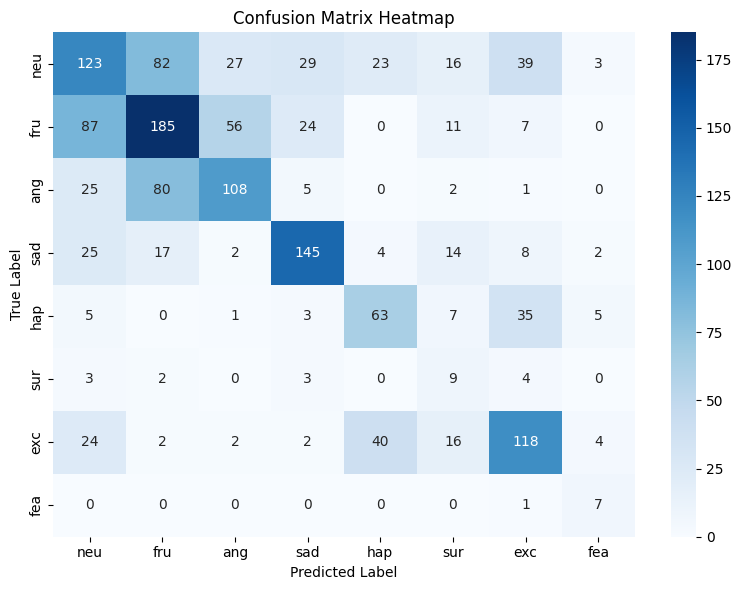

In [29]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)

# Optional: provide class names if available
class_names = ['neu', 'fru', 'ang', 'sad', 'hap', 'sur', 'exc', 'fea']

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

In [30]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
macro_f1 = f1_score(y_test, y_pred_labels, average='macro')

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


In [31]:
macro_f1

0.47772201564368816

In [32]:
inp = text_vectorizer(tf.constant(['Why does this happen to me']))
prediction = model.predict(inp)
id2label[np.argmax(prediction, axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


'sur'

In [33]:
model.save("baseline_model.keras")

## Active Learning

In [ ]:
X_pool = pool['text']

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=200, input_length=150),
    Bidirectional(LSTM(64, return_sequences=True)),  # Note: return_sequences=True
    GlobalMaxPooling1D(),  # This pools the most dominant features across time steps
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Assuming 8 emotion classes
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

d:\Clg\sem6\Project\keras_env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [150]:
def entropy(probabilities, axis=1):
    # This function computes the entropy for each prediction
    # probabilities should be an array of shape (n_samples, n_classes)
    return -np.sum(probabilities * np.log(probabilities + 1e-10), axis=axis)


def manual_label(x_query_sequences):
    """Manual labeling via CLI"""

    texts = x_query_sequences
    labels = []
    for i, text in enumerate(texts):
        print(f"\n[{i+1}] {text}")
        label = input("Label (0: 'neu', 1: 'fru', 2: 'ang', 3: 'sad', 4: 'hap', 5: 'sur', 6: 'exc', 7: 'fea'): ").strip()
        labels.append(int(label))
    return np.array(labels)

In [ ]:
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
f1s_macro = []
f1s_weighted = []
class_distributions = []
unique_classes = np.unique(y_train)

# Parameters
rounds = 10
top_k = 20
maxlen = X_train.shape[1]
tokenizer = text_vectorizer

for i in range(rounds):
    print(f"\n🔁 Active Learning Round {i+1}/{rounds}")

    # 🔁 Step 1: Update class weights dynamically
    class_weights_dict = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_train
    )
    class_weights = dict(enumerate(class_weights_dict))

    # 🔁 Step 2: Train model
    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_test, y_test),
        batch_size=32,
        epochs=20,
        callbacks=[early_stop, reduce_lr],
        class_weight=class_weights,
        verbose=1
    )

    # 🔁 Step 3: Predict on pool & compute uncertainty
    X_pool_vec = text_vectorizer(X_pool)
    probs = model.predict(X_pool_vec)
    uncertainties = entropy(probs, axis=1)

    # 🔁 Step 4: Select uncertain samples (diverse & top-K)
    N = 5 * top_k
    uncertain_idx = np.argsort(uncertainties)[-N:]
    query_idx = np.random.choice(uncertain_idx, size=top_k, replace=False)
    X_query = tf.gather(X_pool, query_idx)

    # 🔁 Step 5: Manually label samples
    y_query = manual_label(X_query)
    X_query_vec = text_vectorizer(X_query)

    # 🔁 Step 6: Add to training set
    X_train = np.concatenate([X_train, X_query_vec], axis=0)
    y_train = np.concatenate([y_train, y_query], axis=0)

    # 🔁 Step 7: Remove from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)

    # 🔁 Step 8: Save loss and accuracy
    train_loss = history.history['loss'][-1]
    train_acc = history.history['accuracy'][-1]
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # 🔁 Step 9: Compute F1
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    # y_true_labels = np.argmax(y_test, axis=1)

    f1_macro = f1_score(y_test, y_pred_labels, average='macro')
    f1_weighted = f1_score(y_test, y_pred_labels, average='weighted')
    
    f1s_macro.append(f1_macro)
    f1s_weighted.append(f1_weighted)

    # 🔁 Step 10: Track class distribution
    class_counts = Counter(y_train)
    class_distributions.append([class_counts.get(cls, 0) for cls in unique_classes])

    print(f"✅ Test Accuracy after round {i+1}: {test_acc:.4f}")
    print(f"📊 Macro F1: {f1_macro:.4f}, Weighted F1: {f1_weighted:.4f}")



🔁 Active Learning Round 1/10
Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.1512 - loss: 2.5029 - val_accuracy: 0.2463 - val_loss: 1.9231 - learning_rate: 0.0010
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.2502 - loss: 1.8241 - val_accuracy: 0.3645 - val_loss: 1.6238 - learning_rate: 0.0010
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.3899 - loss: 1.4001 - val_accuracy: 0.3579 - val_loss: 1.5050 - learning_rate: 0.0010
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.4193 - loss: 1.2529 - val_accuracy: 0.3579 - val_loss: 1.4731 - learning_rate: 0.0010
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.4726 - loss: 1.0930 - val_accuracy: 0.4495 - val_loss: 1.3356 - learning_rate: 0.0010
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.5099 - loss: 1.0333 - val_accuracy: 0.4416 - val_loss: 1.3747 - learning_rate: 0.0010
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 

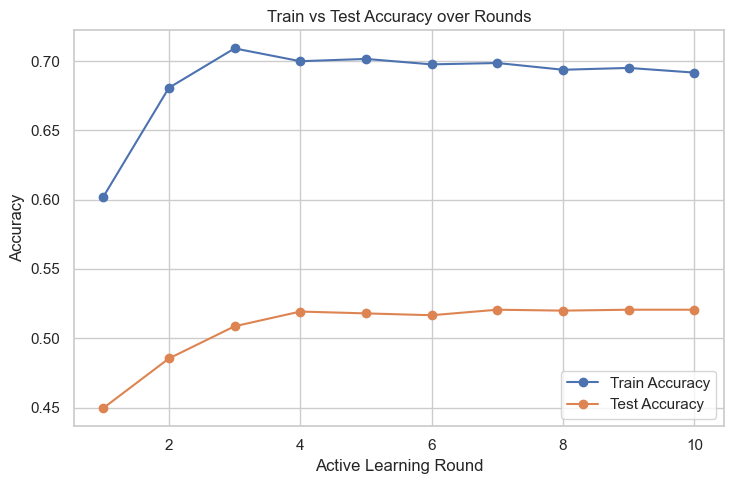

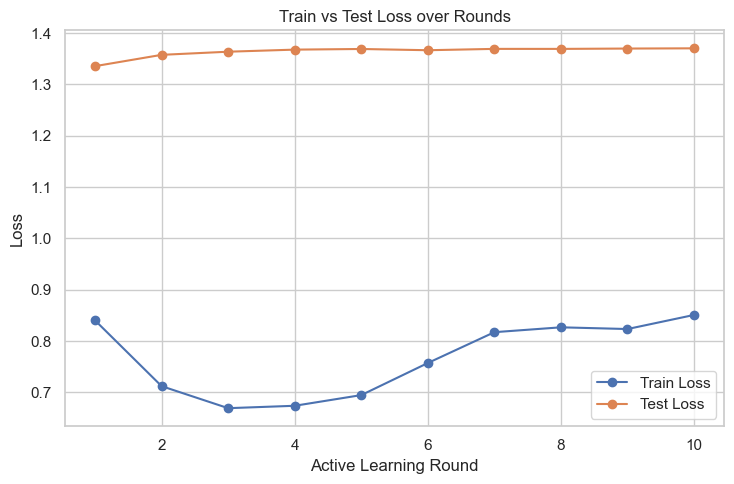

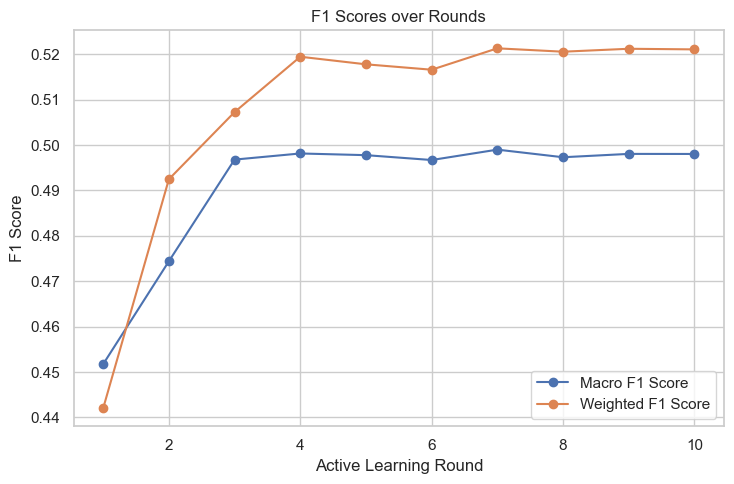

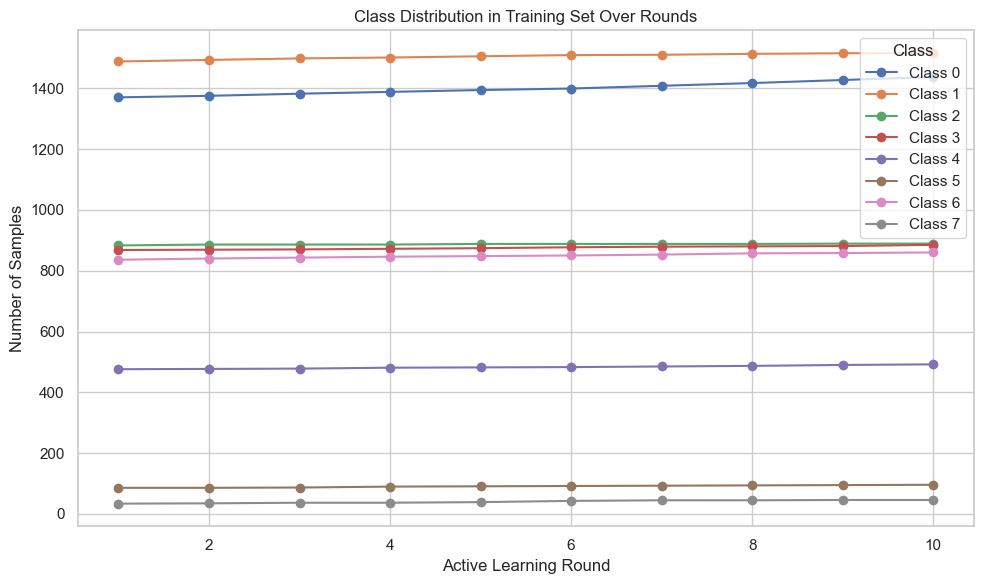

In [168]:
# Set Seaborn style
sns.set(style='whitegrid')

rounds_range = range(1, rounds + 1)

# 📈 Plot 1: Train and Test Accuracy
plt.figure(figsize=(7.5, 5))
plt.plot(rounds_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(rounds_range, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Train vs Test Accuracy over Rounds')
plt.xlabel('Active Learning Round')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# 📉 Plot 2: Train and Test Loss
plt.figure(figsize=(7.5, 5))
plt.plot(rounds_range, train_losses, label='Train Loss', marker='o')
plt.plot(rounds_range, test_losses, label='Test Loss', marker='o')
plt.title('Train vs Test Loss over Rounds')
plt.xlabel('Active Learning Round')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Plot 3: F1 Scores
plt.figure(figsize=(7.5, 5))
plt.plot(rounds_range, f1s_macro, label='Macro F1 Score', marker='o')
plt.plot(rounds_range, f1s_weighted, label='Weighted F1 Score', marker='o')
plt.title('F1 Scores over Rounds')
plt.xlabel('Active Learning Round')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

# 🧮 Plot 4: Class Distribution Over Rounds
class_distributions_array = np.array(class_distributions)

plt.figure(figsize=(10, 6))
for idx, cls in enumerate(unique_classes):
    plt.plot(rounds_range, class_distributions_array[:, idx], label=f'Class {cls}', marker='o')
plt.title('Class Distribution in Training Set Over Rounds')
plt.xlabel('Active Learning Round')
plt.ylabel('Number of Samples')
plt.legend(title="Class")
plt.tight_layout()
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

           0       0.44      0.37      0.41       342
           1       0.54      0.46      0.50       370
           2       0.51      0.57      0.54       221
           3       0.71      0.73      0.72       217
           4       0.41      0.55      0.47       119
           5       0.18      0.43      0.25        21
           6       0.60      0.56      0.58       208
           7       0.37      0.88      0.52         8

    accuracy                           0.52      1506
   macro avg       0.47      0.57      0.50      1506
weighted avg       0.53      0.52      0.52      1506



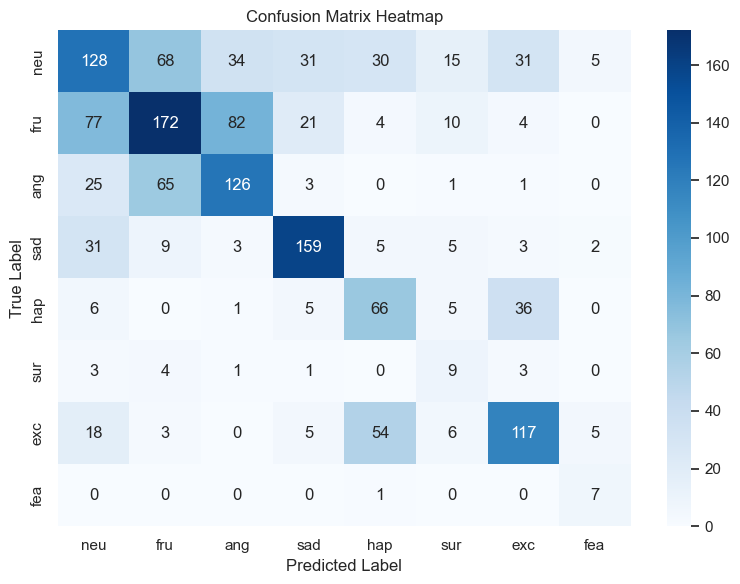

In [174]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)

# Optional: provide class names if available
class_names = ['neu', 'fru', 'ang', 'sad', 'hap', 'sur', 'exc', 'fea']

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

In [175]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
macro_f1 = f1_score(y_test, y_pred_labels, average='macro')

macro_f1

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


0.4980473688449747

In [179]:
inp = text_vectorizer(tf.constant(['What do you think? Not sure. God, what is wrong with you?!']))
prediction = model.predict(inp)
id2label[np.argmax(prediction, axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


'fea'

In [162]:
model.save("active_model.keras")